In [4]:
import numpy as np
from scipy.stats import norm
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import datetime as dt
from scipy.optimize import least_squares


In [5]:
#dataimport
calldata=pd.read_csv('goog_call.csv',index_col=None)
putdata=pd.read_csv('goog_put.csv')
rate_df = pd.read_csv('discount.csv',index_col=0)
calldata['Midprice']=(calldata['best_bid']+calldata['best_offer'])/2
putdata['Midprice']=(putdata['best_bid']+putdata['best_offer'])/2

In [6]:
#Days counts
today = dt.date(2013, 8, 30)
expiry = dt.date(2015, 1, 17)
T = (expiry-today).days/365.0
print((expiry-today).days)

505


In [30]:
#F price and liquidity option selection
S=846.9
#r 
r=(rate_df.loc[565,].values-rate_df.loc[474,].values)*((505-474)/(565-474))+rate_df.loc[474,].values
r=r/100
F=S*np.exp(r*T)
F=float(F)
calldata=calldata[calldata['strike']>=F]
putdata=putdata[putdata['strike']<F]
data=pd.concat([putdata,calldata])
data=data.set_index('strike',drop=False)
calldata=calldata.set_index('strike',drop=False)
putdata=putdata.set_index('strike',drop=False)
print(r)

[0.0040536]


In [8]:
#derive impliedVol
from scipy.optimize import brentq

def BlackScholesCall(S, K, r, sigma, T):
    d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)
def BlackScholesPut(S, K, r, sigma, T):
    d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return  K*np.exp(-r*T)*norm.cdf(-d2)-S*norm.cdf(-d1) 

def impliedCallVolatility(S, K, r, price, T):
    impliedVol = brentq(lambda x: price -
                        BlackScholesCall(S, K, r, x, T),
                        1e-6, 1)
    return impliedVol
def impliedPutVolatility(S, K, r, price, T):
    impliedVol = brentq(lambda x: price -
                        BlackScholesPut(S, K, r, x, T),
                        1e-6, 1)
    return impliedVol

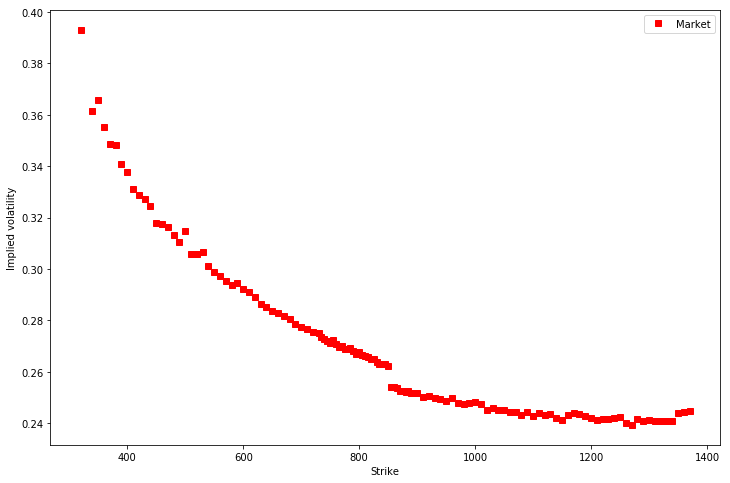

In [9]:
#derive impliedVol in apply functions
Callvol=calldata.apply(lambda x: impliedCallVolatility(S=S,K=x['strike'],
                                                       r=r,price=x['Midprice'],T=T),axis=1)
Putvol=putdata.apply(lambda x: impliedPutVolatility(S=S,K=x['strike'],
                                                       r=r,price=x['Midprice'],T=T),axis=1)

Marketimpvol=pd.concat([Putvol,Callvol])
data['Market']=Marketimpvol
ax=data[['Market']].plot(figsize=[12,8],style=['rs'],linewidth=2.0)
plt.xlabel('Strike')
plt.ylabel('Implied volatility')
plt.show()

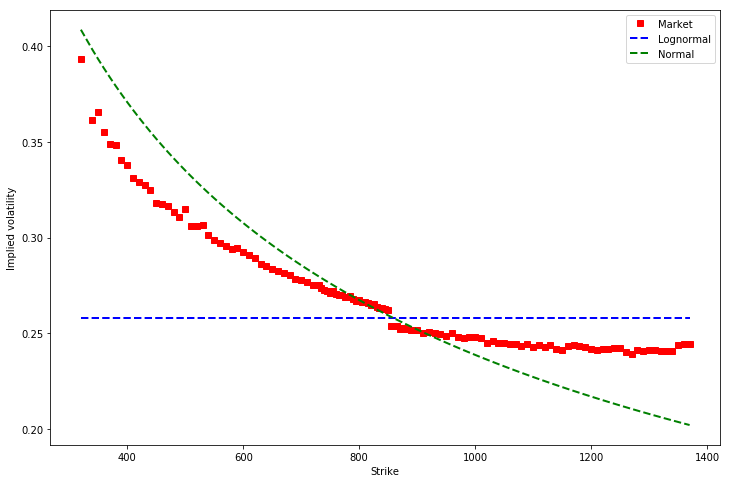

In [10]:
#Normal & lognormal impvol
def DDCall(F, K, r, sigma, T, beta):
    F=F/beta
    K=K+(1-beta)*F #Here F=F/beta
    sigma=beta*sigma
    d1 = (np.log(F/K)+(sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return F*np.exp(-r*T)*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)

def DDPut(F, K, r, sigma, T, beta):
    F=F/beta
    K=K+(1-beta)*F #Here, F=F/beta
    sigma=beta*sigma
    d1 = (np.log(F/K)+(sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return K*np.exp(-r*T)*norm.cdf(-d2) - F*np.exp(-r*T)*norm.cdf(-d1)

#Collect lognormal vol

beta=1 # When beta=1, DD=BK76lognormal
sigma=(Putvol.iloc[-1]+Callvol.iloc[0])/2 #estimate sigma ATM

Lognormalimpvol = []
for K in data.index.values:
    if K < F:
        price = DDPut(F, K, r, sigma, T, beta)
        impliedvol = impliedPutVolatility(S, K, r, price, T)
    else:
        price = DDCall(F, K, r, sigma, T, beta)
        impliedvol = impliedCallVolatility(S, K, r, price, T)
    Lognormalimpvol.append([K, impliedvol])
    
#Collect normal vol
def BKnormalCall(F, K, r,sigma, T):
    d=(F-K)/(F*sigma*np.sqrt(T))
    D=np.exp(-r*T)
    return D*((F-K)*norm.cdf(d) + F*sigma*np.sqrt(T)*norm.pdf(-d))

sigma=(Putvol.iloc[-1]+Callvol.iloc[0])/2 #estimate sigma ATM

Normalimpvol = []


for K in data.index.values:

    price = BKnormalCall(F, K, r, sigma, T)
    impliedvol = impliedCallVolatility(S, K, r, price, T)
    Normalimpvol.append([K, impliedvol])
    
    
#plotting
df1 = pd.DataFrame(Lognormalimpvol,columns=['strike','Lognormal'])
df1 = df1.set_index('strike')
df2 = pd.DataFrame(Normalimpvol,columns=['strike','Normal'])
df2 = df2.set_index('strike')
data['Lognormal']=df1['Lognormal']
data['Normal']=df2['Normal']
data[['Market','Lognormal','Normal']].plot(figsize=[12,8],style=['rs','b--','g--'],linewidth=2.0)
plt.xlabel('Strike')
plt.ylabel('Implied volatility')
plt.show()


In [31]:
print(sigma)

0.25812694845838613


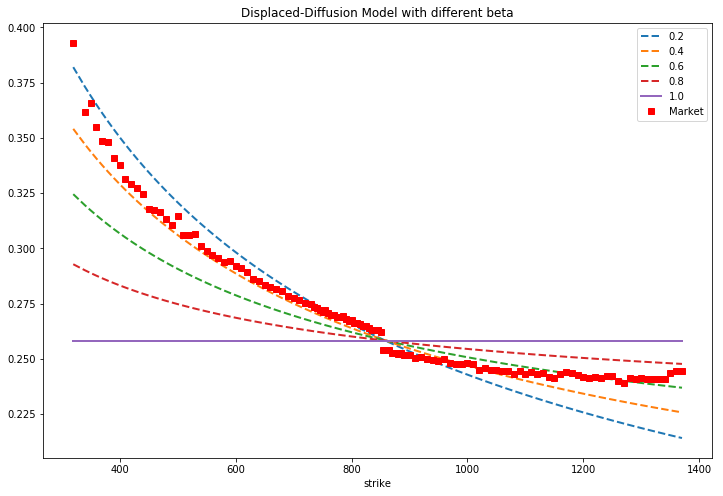

In [29]:
#Displaced-Diffusion Model with different beta
sigma=(Putvol.iloc[-1]+Callvol.iloc[0])/2 #estimate sigma ATM
beta_list=[0.2, 0.4, 0.6, 0.8, 1]
impvol_list=[]

for beta in beta_list:
    imvol=[]
    for K in data.index.values:
        price=DDCall(F,K,r,sigma,T,beta)
        imvol.append(impliedCallVolatility(S, K, r, price, T))
    impvol_list.append(imvol)

impvol_beta=pd.DataFrame(np.transpose(impvol_list),columns=beta_list)
impvol_beta['strike']=data.index
impvol_beta=impvol_beta.set_index('strike')
impvol_beta['Market']=data['Market']
impvol_beta.plot(figsize=[12,8],style=['--','--','--','--','-,','rs'],linewidth=2.0)
plt.title('Displaced-Diffusion Model with different beta')
plt.savefig('beta.png')



[0.36472002] 0.25812694845838613
The beta=0.36 The sigma=0.26


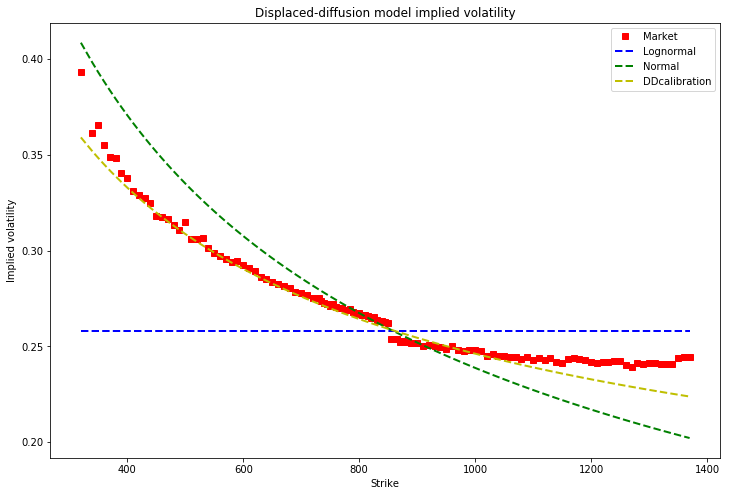

In [28]:
#DD calibration
def DDcalibration(x,S,F,K,r,sigma,T,vols):
    err=0.0
    for i,v in enumerate(vols):
        price=DDCall(F,K[i],r,sigma,T,x)
        impvol=impliedCallVolatility(S, K[i], r, price, T)
        err+=(v-impvol)**2
    return err

initialBeta = 0.8
res1 = least_squares(lambda x: DDcalibration(x,S,F,data.index.values,r,sigma,T,data['Market'].values),initialBeta)

#Collect New DDvol
beta=res1.x 
sigma=(Putvol.iloc[-1]+Callvol.iloc[0])/2 #estimate sigma ATM
print('The beta=%0.2f'%beta,'The sigma=%0.2f'%sigma)
DDimpvol = []
for K in data.index.values:
    if K < F:
        price = DDPut(F, K, r, sigma, T, beta)
        impliedvol = impliedPutVolatility(S, K, r, price, T)
        
    else:
        price = DDCall(F, K, r, sigma, T, beta)
        impliedvol = impliedCallVolatility(S, K, r, price, T)
    DDimpvol.append([K, impliedvol])
    
    
#plotting
df3 = pd.DataFrame(DDimpvol,columns=['strike','DDcalibration'])
df3 = df3.set_index('strike')
data['DDcalibration']=df3['DDcalibration']
data[['Market','Lognormal','Normal','DDcalibration']].plot(figsize=[12,8],style=['rs','b--','g--','y--'],linewidth=2.0)
plt.xlabel('Strike')
plt.ylabel('Implied volatility')
plt.title('Displaced-diffusion model implied volatility')
plt.show()

[ 0.99077728 -0.28514716  0.35222713]


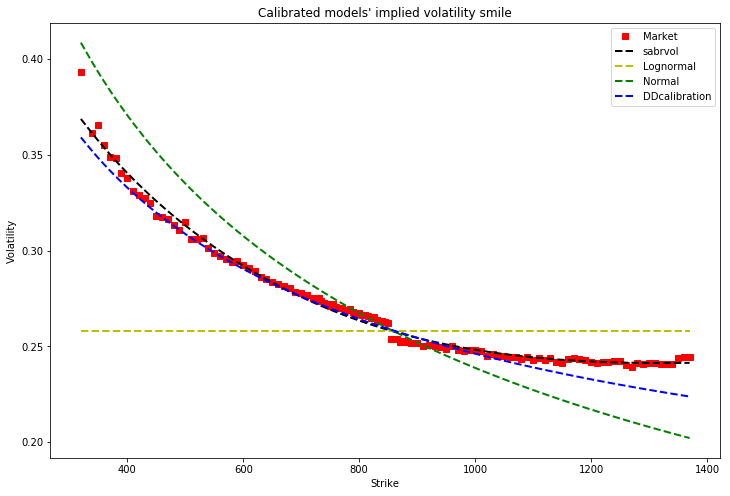

In [21]:
#SABR calibration
def SABR(F, K, T, alpha, beta, rho, nu):
    X = K
    if F == K:
        numer1 = (((1 - beta)**2)/24)*alpha*alpha/(F**(2 - 2*beta))
        numer2 = 0.25*rho*beta*nu*alpha/(F**(1 - beta))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        VolAtm = alpha*(1 + (numer1 + numer2 + numer3)*T)/(F**(1-beta))
        sabrsigma = VolAtm
    else:
        z = (nu/alpha)*((F*X)**(0.5*(1-beta)))*np.log(F/X)
        zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))
        numer1 = (((1 - beta)**2)/24)*((alpha*alpha)/((F*X)**(1 - beta)))
        numer2 = 0.25*rho*beta*nu*alpha/((F*X)**((1 - beta)/2))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        numer = alpha*(1 + (numer1 + numer2 + numer3)*T)*z
        denom1 = ((1 - beta)**2/24)*(np.log(F/X))**2
        denom2 = (((1 - beta)**4)/1920)*((np.log(F/X))**4)
        denom = ((F*X)**((1 - beta)/2))*(1 + denom1 + denom2)*zhi
        sabrsigma = numer/denom

    return sabrsigma

#find alpha, rho, nu
def sabrcalibration(x, strikes, vols, F, T):
    err = 0.0
    for i, vol in enumerate(vols):
        err += (vol - SABR(F, strikes[i], T,
                           x[0], 0.8, x[1], x[2]))**2

    return err


initialGuess = [0.02, 0.2, 0.1]
res = least_squares(lambda x: sabrcalibration(x,
                                              data.index.values,
                                              data['Market'].values,
                                              F,
                                              T),
                    initialGuess)
alpha = res.x[0]
beta = 0.8
rho = res.x[1]
nu = res.x[2]
print(res.x)
#collect sabr
sabrvol = []
for K in data.index.values:
    sabrVol=SABR(F, K, T, alpha, beta, rho, nu)
    sabrvol.append([K, sabrVol])    
#plot  
df2=pd.DataFrame(sabrvol, columns=['strike', 'sabrvol'])
df2=df2.set_index('strike',drop=False)
data['sabrvol'] = df2['sabrvol']
data[['Market','sabrvol','Lognormal','Normal','DDcalibration']].plot(figsize=[12,8],style=['rs','k--','y--','g--','b--'],linewidth=2.0)

plt.xlabel('Strike')
plt.ylabel('Volatility')
plt.title('Calibrated models\' implied volatility smile')
plt.savefig('part2.png')
plt.show()

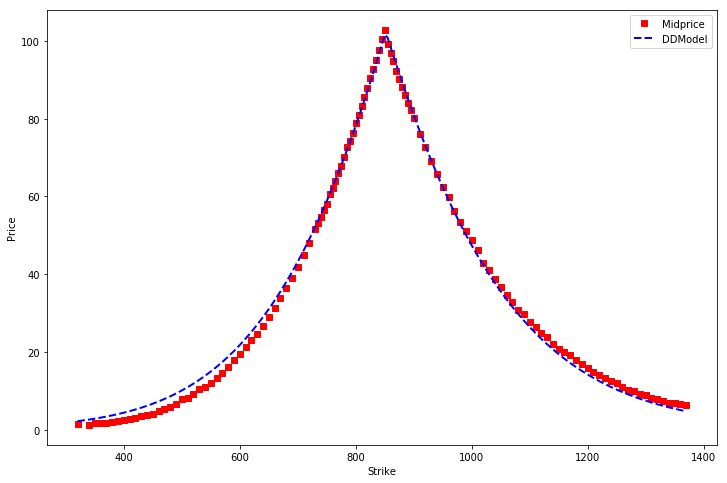

In [14]:
#derive Displaced-difussion model
def DDCall(F, K, r, sigma, T, beta):
    F=F/beta
    K=K+(1-beta)*F #Here F=F/beta
    sigma=beta*sigma
    d1 = (np.log(F/K)+(sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return F*np.exp(-r*T)*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)

def DDPut(F, K, r, sigma, T, beta):
    F=F/beta
    K=K+(1-beta)*F #Here, F=F/beta
    sigma=beta*sigma
    d1 = (np.log(F/K)+(sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return K*np.exp(-r*T)*norm.cdf(-d2) - F*np.exp(-r*T)*norm.cdf(-d1)






#DD model price
DDprice = []
beta=0.8
for K,sigma in zip(data.index.values,data['sabrvol'].values) :
    if K>=F:
        ddprice=DDCall(F, K, r, sigma, T, beta)
        ddprice=float(ddprice)
        DDprice.append([K,ddprice])
    else:
        ddprice=DDPut(F, K, r, sigma, T, beta)
        ddprice=float(ddprice)
        DDprice.append([K,ddprice])    


#Plot
dfDDprice=pd.DataFrame(DDprice, columns=['strike', 'DDModel'])
dfDDprice=dfDDprice.set_index('strike',drop=False)
data['DDModel'] = dfDDprice['DDModel']
data[['Midprice','DDModel']].plot(figsize=[12,8],style=['rs','b--'],linewidth=2.0)

plt.xlabel('Strike')
plt.ylabel('Price')
plt.show()
